In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


We\'ll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called `Lang` which has word → index (`word2index`) and index → word
(`index2word`) dictionaries, as well as a count of each word
`word2count` which will be used to replace rare words later.


In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.


In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the `reverse`
flag to reverse the pairs.


In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('fra.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we\'ll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we\'re filtering to sentences that translate to
the form \"I am\" or \"He is\" etc. (accounting for apostrophes replaced
earlier).


In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-   Read text file and split into lines, split lines into pairs
-   Normalize text, filter by length and content
-   Make word lists from sentences in pairs


In [ ]:
def prepareData(lang1, lang2, reverse=False,):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'hin', True)
print(random.choice(pairs))

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
hin 5751
eng 3748
['il est cruel et sans c ur', 'he s cruel and heartless']


In [ ]:
print(pairs)

[['je vais bien', 'i m ok'], ['ca va', 'i m ok'], ['je suis tom', 'i m tom'], ['je suis gras', 'i m fat'], ['je suis gros', 'i m fat'], ['je suis en forme', 'i m fit'], ['je suis touche !', 'i m hit !'], ['je suis touchee !', 'i m hit !'], ['je suis malade', 'i m ill'], ['je suis fou', 'i m mad'], ['je suis folle', 'i m mad'], ['je suis en colere', 'i m mad'], ['je suis triste', 'i m sad'], ['j ai un coup de cafard', 'i m sad'], ['je suis malheureux', 'i m sad'], ['je suis timide', 'i m shy'], ['je suis mouille', 'i m wet'], ['je suis mouillee', 'i m wet'], ['il est mouille', 'he s wet'], ['je suis tom', 'i am tom'], ['je suis revenu', 'i m back'], ['me revoila', 'i m back'], ['je suis chauve', 'i m bald'], ['je suis occupe', 'i m busy'], ['je suis occupee', 'i m busy'], ['je suis calme', 'i m calm'], ['j ai froid', 'i m cold'], ['je suis detendu', 'i m cool'], ['je suis detendue', 'i m cool'], ['je suis sourd', 'i m deaf'], ['je suis sourde', 'i m deaf'], ['j en ai fini', 'i m done'],

The Encoder
===========

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/encoder-network.png)


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Simple Decoder
==============

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string `<SOS>`
token, and the first hidden state is the context vector (the encoder\'s
last hidden state).

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/decoder-network.png)


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

Attention Decoder
=================

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to \"focus\" on a different part of
the encoder\'s outputs for every step of the decoder\'s own outputs.
First we calculate a set of *attention weights*. These will be
multiplied by the encoder output vectors to create a weighted
combination. The result (called `attn_applied` in the code) should
contain information about that specific part of the input sequence, and
thus help the decoder choose the right output words.

![](https://i.imgur.com/1152PYf.png)

Calculating the attention weights is done with another feed-forward
layer `attn`, using the decoder\'s input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/attention-decoder-network.png)

Bahdanau attention, also known as additive attention, is a commonly used
attention mechanism in sequence-to-sequence models, particularly in
neural machine translation tasks. It was introduced by Bahdanau et al.
in their paper titled [Neural Machine Translation by Jointly Learning to
Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). This
attention mechanism employs a learned alignment model to compute
attention scores between the encoder and decoder hidden states. It
utilizes a feed-forward neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as
Luong attention, which computes attention scores by taking the dot
product between the decoder hidden state and the encoder hidden states.
It does not involve the non-linear transformation used in Bahdanau
attention.

In this tutorial, we will be using Bahdanau attention. However, it would
be a valuable exercise to explore modifying the attention mechanism to
use Luong attention.


In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Bahdanau attention, also known as additive attention, is a commonly used attention mechanism in sequence-to-sequence models, particularly in neural machine translation tasks. It was introduced by Bahdanau et al. in their paper titled Neural Machine Translation by Jointly Learning to Align and Translate. This attention mechanism employs a learned alignment model to compute attention scores between the encoder and decoder hidden states. It utilizes a feed-forward neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as Luong attention, which computes attention scores by taking the dot product between the decoder hidden state and the encoder hidden states. It does not involve the non-linear transformation used in Bahdanau attention.

In this tutorial, we will be using Bahdanau attention. However, it would be a valuable exercise to explore modifying the attention mechanism to use Luong attention.

Traning the model with Additive Attention

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
1m 0s (- 3m 1s) (5 25%) 1.3802
2m 0s (- 2m 0s) (10 50%) 0.5507
2m 57s (- 0m 59s) (15 75%) 0.2903
3m 55s (- 0m 0s) (20 100%) 0.1824


In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> tu n es plus le bienvenu ici
= you are no longer welcome here
< you re no longer welcome here <EOS>

> elles sont autosuffisantes
= they re self sufficient
< they are self sufficient <EOS>

> ils sont intacts
= they re undamaged
< they re undamaged <EOS>

> j essaie de rester calme
= i m trying to stay calm
< i m trying to stay calm about <EOS>

> ils sont en danger
= they re in danger
< they re in danger <EOS>

> je suis en train de jouer avec mes amies
= i m playing with my friends
< i m playing with my friends <EOS>

> tu es un grand garcon
= you re a big boy
< you re a big boy <EOS>

> tu es probablement fatigue apres un vol aussi long
= you re probably tired after such a long flight
< you re probably tired after such a long flight <EOS>

> il travaille dur en vue de reussir son examen
= he is working hard to pass the examination
< he is working hard to pass the examination <EOS>

> vous etes tenace
= you re resilient
< you re resilient <EOS>



In [ ]:
%matplotlib inline

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


<ipython-input-27-332b9c61fc98>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-27-332b9c61fc98>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

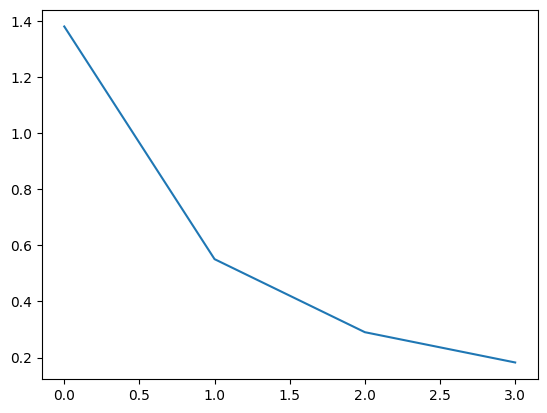

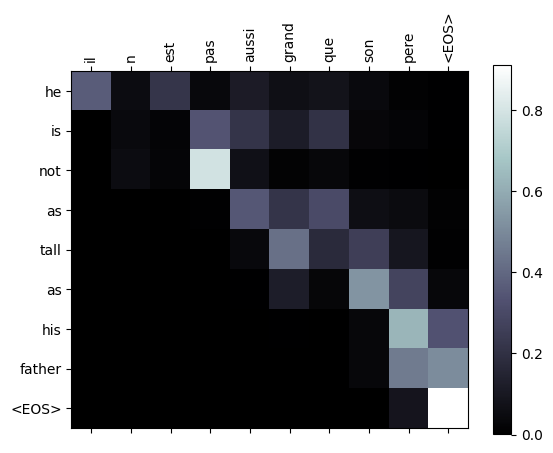

input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


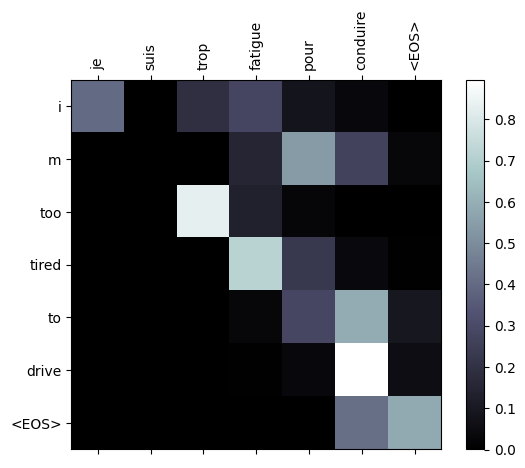

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


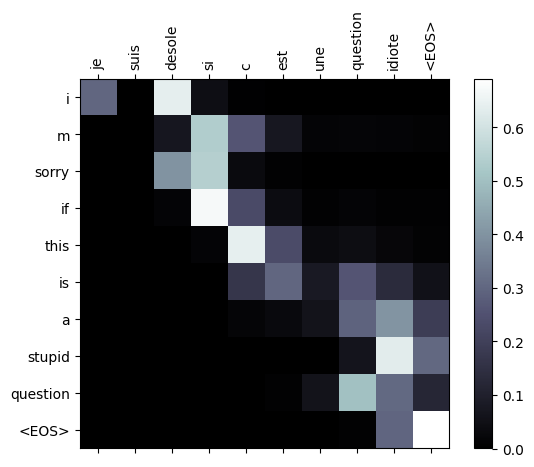

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


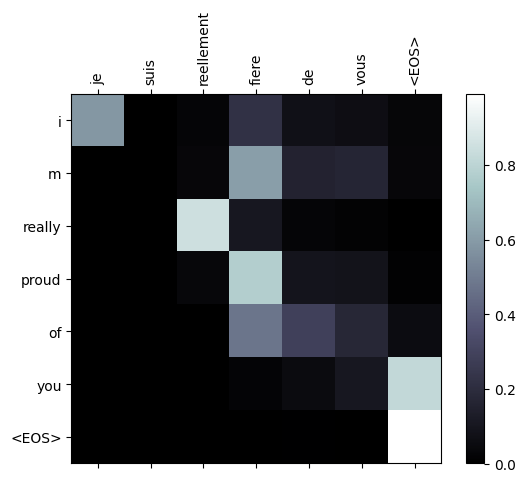

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215), or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting
of two RNNs called the encoder and decoder. The encoder reads an input
sequence and outputs a single vector, and the decoder reads that vector
to produce an output sequence.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence `Je ne suis pas le chat noir` →
`I am not the black cat`. Most of the words in the input sentence have a
direct translation in the output sentence, but are in slightly different
orders, e.g. `chat noir` and `black cat`. Because of the `ne/pas`
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the \"meaning\" of the input sequence into a single
vector --- a single point in some N dimensional space of sentences.


Training the model for Seq to Seq model without any attention

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
0m 30s (- 1m 32s) (5 25%) 1.5800
1m 1s (- 1m 1s) (10 50%) 0.8133
1m 32s (- 0m 30s) (15 75%) 0.5288
2m 2s (- 0m 0s) (20 100%) 0.3712


<Figure size 640x480 with 0 Axes>

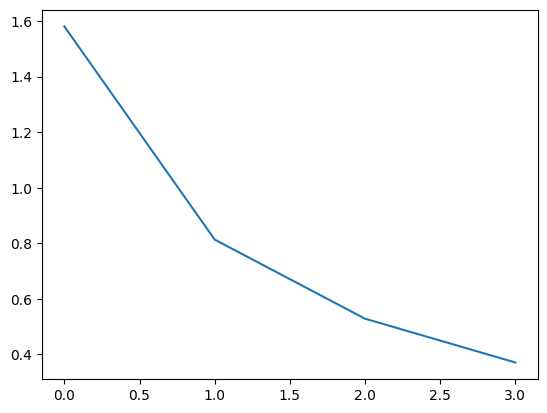

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> nous sommes juste fatiguees
= we re just tired
< we re just tired today <EOS>

> je me battrai jusqu au bout
= i m going to fight till the end
< i m going to hide school today <EOS>

> vous etes assez mignons quand vous etes en colere
= you re kind of cute when you re mad
< you re kind of cute when you re mad <EOS>

> il va se presenter aux elections municipales
= he is going to run for mayor
< he is going to visit the going out the summer

> je suis tres satisfait de mon achat
= i m very happy with my purchase
< i m very happy with my purchase <EOS>

> je suis desole je ne veux pas m immiscer
= i m sorry i don t mean to pry
< i m sorry i don t recognize you <EOS>

> ils sont avec moi
= they re with me
< they are with my friends <EOS>

> je suis toujours celibataire
= i m still single
< i m still single with her <EOS>

> c est une fille mais elle est brave
= she s a girl but she s brave
< she s a friend of your daughter <EOS>

> je travaille sur une nouvelle idee
= i m working on a n

Creating dot product attention function

In [ ]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()
        self.attention = nn.Linear(hidden_size, hidden_size)

    def forward(self, query, keys):
        attention_scores = torch.bmm(query, keys.transpose(1, 2))
        attention_weights = F.softmax(attention_scores, dim=-1)
        context = torch.bmm(attention_weights, keys)
        return context, attention_weights

class AttnDecoderRNNL(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNNL, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = LuongAttention(hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        decoder_hidden = encoder_hidden  # No need to modify initial hidden state

        decoder_outputs = []
        attentions = []

        for i in range(seq_len):  # Assuming seq_len is the maximum length
            # Initial input is <SOS> token
            decoder_input = torch.full((batch_size, 1), SOS_token, dtype=torch.long, device=device)

            # Embed the input
            embedded = self.embedding(decoder_input)
            embedded = self.dropout(embedded)

            # Forward step
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                embedded, decoder_hidden, encoder_outputs
            )

            # Store output and attention
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

        # Concatenate outputs along the time dimension
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

        # Concatenate attentions along the time dimension
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        # Pass through GRU
        output, hidden = self.gru(input, hidden)

        # Compute attention
        context, attn_weights = self.attention(output, encoder_outputs)

        # Concatenate output and context for input to the final layer
        combined_output = torch.cat((output, context), dim=2)

        # Apply final linear layer
        output = self.out(combined_output)

        return output, hidden, attn_weights


Trraining with Luong Attention

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
0m 39s (- 1m 58s) (5 25%) 1.7358
1m 19s (- 1m 19s) (10 50%) 0.8067
1m 59s (- 0m 39s) (15 75%) 0.5463
2m 38s (- 0m 0s) (20 100%) 0.4291


<Figure size 640x480 with 0 Axes>

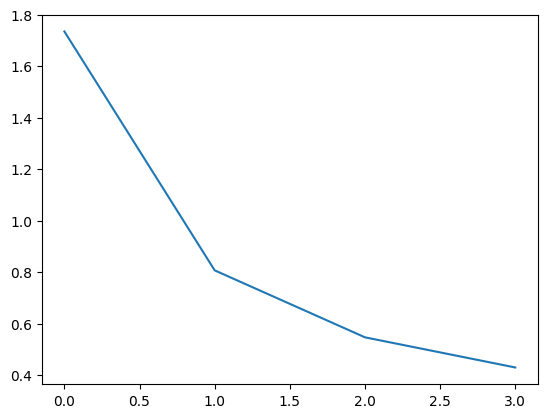

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNNL(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

Evaluating luong attention model

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> j ai peur des ours
= i am afraid of bears
< i m afraid of of bears

> ils sont a l etage
= they re upstairs
< they re upstairs to <EOS>

> j ai de l experience
= i m experienced
< i am experienced the the <EOS>

> il est le mouton noir de la famille
= he s the black sheep of the family
< he s the black sheep in the family <EOS>

> elles sont mignonnes
= they re cute
< they re kind they

> elle est une mere tres avisee
= she s a very wise mother
< she s a very wise wise wise

> il n est rien d autre qu un enfant
= he is nothing but a child
< he is nothing but a child <EOS>

> tu es gentille
= you re kind
< you re kind kind

> je n ecarte pas cette possibilite
= i m not discounting that possibility
< i m not discounting that that possibility

> je suis le cousin de tom
= i m tom s cousin
< i m tom tom s s <EOS>



input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


<ipython-input-33-332b9c61fc98>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-33-332b9c61fc98>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


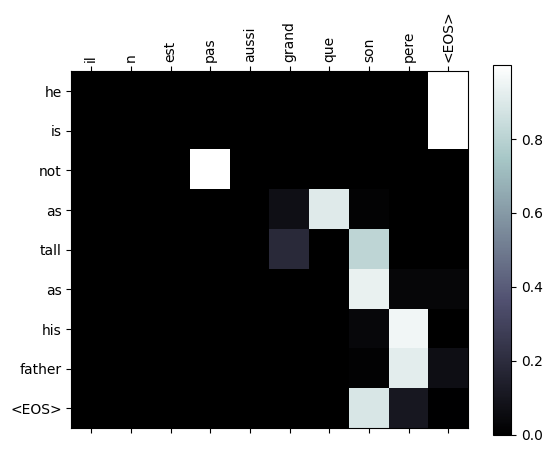

input = je suis trop fatigue pour conduire
output = i m too tired to drive to


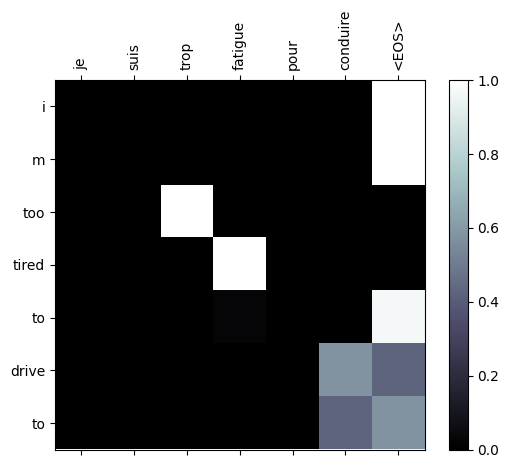

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


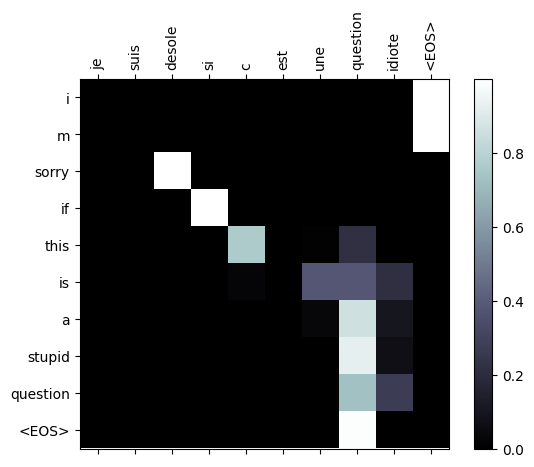

input = je suis reellement fiere de vous
output = i m really proud of of you


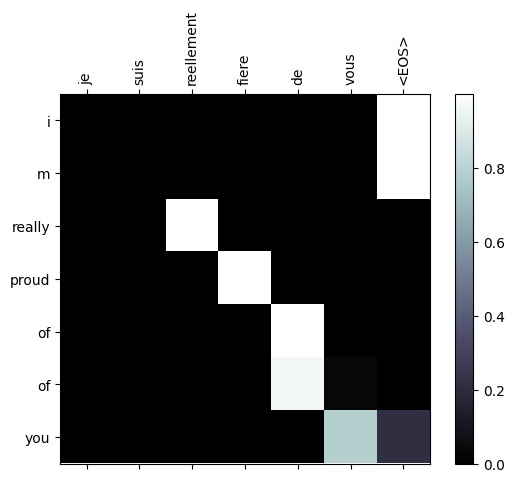

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')